In [54]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import html
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [13]:
html_file = 'watch-history.html'

with open(html_file, 'r', encoding='utf-8') as f:
    soup = BeautifulSoup(f, 'html.parser')

In [14]:
records = []
# Google uses this specific class for activity entries
cells = soup.find_all("div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1")

for cell in cells:
    text = cell.get_text(separator="|", strip=True)
    if not text.startswith("Watched"):
        continue

    # Unescape HTML characters (like &amp; to &)
    cell_clean = html.unescape(str(cell))

    # Extract Title and Video URL
    video_match = re.search(r'href="(https://www\.youtube\.com/watch\?v=[^"]+)">([^<]+)</a>', cell_clean)
    video_url = video_match.group(1) if video_match else None
    video_title = video_match.group(2) if video_match else "Unknown Video"

    # Extract Channel Name and Channel URL
    channel_match = re.search(r'href="(https://www\.youtube\.com/(?:channel|c|@)/[^"]+)">([^<]+)</a>', cell_clean)
    channel_url = channel_match.group(1) if channel_match else None
    channel_name = channel_match.group(2) if channel_match else "Unknown Channel"

    # Extract Timestamp (it's the last part after the last <br>)
    parts = text.split("|")
    timestamp = parts[-1] if parts else None

    records.append({
        "title": video_title,
        "video_url": video_url,
        "channel": channel_name,
        "channel_url": channel_url,
        "timestamp": timestamp
    })

In [15]:
watch_df = pd.DataFrame(records)
watch_df.to_csv('watch_history_cleaned.csv', index=False)
watch_df.head()

,title,video_url,channel,channel_url,timestamp
0,DP 56. Count Square Submatrices with All Ones ...,https://www.youtube.com/watch?v=auS1fynpnjo,take U forward,https://www.youtube.com/channel/UCJskGeByzRRSv...,"18 Dec 2025, 10:10:39 GMT+05:30"
1,DP 55. Maximum Rectangle Area with all 1's | D...,https://www.youtube.com/watch?v=tOylVCugy9k,take U forward,https://www.youtube.com/channel/UCJskGeByzRRSv...,"18 Dec 2025, 10:01:59 GMT+05:30"
2,DP 53. Palindrome Partitioning - II | Front Pa...,https://www.youtube.com/watch?v=_H8V5hJUGd0,take U forward,https://www.youtube.com/channel/UCJskGeByzRRSv...,"18 Dec 2025, 09:23:48 GMT+05:30"
3,DP 54. Partition Array for Maximum Sum | Front...,https://www.youtube.com/watch?v=PhWWJmaKfMc,take U forward,https://www.youtube.com/channel/UCJskGeByzRRSv...,"18 Dec 2025, 08:20:19 GMT+05:30"
4,Unlock This 100% Hidden Desktop App – Secret F...,https://www.youtube.com/watch?v=yCB3BWXIOtY,Unknown Channel,None,"18 Dec 2025, 07:47:05 GMT+05:30"


PREPROCESSING AND FEATURE ENGINEERING

In [16]:
history = pd.read_csv('watch_history_cleaned.csv')
subs = pd.read_csv('subscriptions.csv')
later = pd.read_csv('Watch later videos.csv')

In [17]:
# Remove any rows that don't have a title (usually ads or system errors)
history = history.dropna(subset=['title']).reset_index(drop=True)

In [18]:
# Remove the 'GMT+05:30' part so it's just the date and time
history['timestamp_clean'] = history['timestamp'].str.replace(' GMT.*', '', regex=True)

In [19]:
# Convert to actual datetime objects - 'mixed' handles "Sept" vs "Sep"
history['timestamp'] = pd.to_datetime(history['timestamp_clean'], format='mixed', dayfirst=True)

In [20]:
# feature engg
history['hour'] = history['timestamp'].dt.hour
history['day_of_week'] = history['timestamp'].dt.day_name()
history['month'] = history['timestamp'].dt.month_name()
history['year'] = history['timestamp'].dt.year
history['is_weekend'] = history['timestamp'].dt.dayofweek >= 5

In [21]:
# categorize time of day for future ML clustering
def get_time_category(hr):
    if 5 <= hr < 12: return 'Morning'
    if 12 <= hr < 17: return 'Afternoon'
    if 17 <= hr < 21: return 'Evening'
    return 'Night'

history['time_of_day'] = history['hour'].apply(get_time_category)

In [22]:
# Extract IDs to match across files
history['video_id'] = history['video_url'].str.extract(r'v=([^&]+)')
history['channel_id'] = history['channel_url'].str.extract(r'channel/([^/]+)')

# is this a channel I am subscribed to?
sub_ids = subs['Channel ID'].unique()
history['is_subscribed'] = history['channel_id'].isin(sub_ids)

# did I watch this after saving it to "Watch Later"?
later_ids = later['Video ID'].unique()
history['from_watch_later'] = history['video_id'].isin(later_ids)

In [23]:
history = history.drop(columns=['timestamp_clean'])

In [41]:
history = history[history['channel'] != 'Unknown Channel'].reset_index(drop=True)

In [118]:
history.head()

,title,video_url,channel,channel_url,timestamp,hour,day_of_week,month,year,is_weekend,...,is_subscribed,from_watch_later,year_month,time_diff,new_session,session_id,cluster_x,cluster_y,cluster,persona
0,75% Criteria & JEE MAIN 2023 POSTPONEMENT LATE...,https://www.youtube.com/watch?v=EX5ljt1vuA0,Neha Agrawal Mathematically Inclined,https://www.youtube.com/channel/UCfSUSGxsZBBE3...,2023-01-05 18:16:45,18,Thursday,January,2023,False,...,False,False,2023-01,NaN,0,0,1,1,1,The Post-Work Decompressor
1,Ye question to pakka ayega😱 NAME Reaction LEAK...,https://www.youtube.com/watch?v=8dFt9KumgzA,PW ka Mausam,https://www.youtube.com/channel/UCM7n79HwBqaUT...,2023-01-05 18:22:26,18,Thursday,January,2023,False,...,False,False,2023-01,5.683333,0,0,1,1,1,The Post-Work Decompressor
2,JEE January 2023 Question yahi se aayega 100%g...,https://www.youtube.com/watch?v=Qt7wqozhVEI,PW ka Mausam,https://www.youtube.com/channel/UCM7n79HwBqaUT...,2023-01-05 18:23:38,18,Thursday,January,2023,False,...,False,False,2023-01,1.200000,0,0,1,1,1,The Post-Work Decompressor
3,Last 15 Days : JEE MAIN 2023 Schedule in 1 min...,https://www.youtube.com/watch?v=DbhiWva9csk,Neha Agrawal Mathematically Inclined,https://www.youtube.com/channel/UCfSUSGxsZBBE3...,2023-01-07 15:35:10,15,Saturday,January,2023,True,...,False,False,2023-01,2711.533333,1,1,0,0,0,The Weekend Wanderer
4,"JEE Mains 2023 ""160 Marks"" Complete Checklist ...",https://www.youtube.com/watch?v=zsfxU3aj1Ds,Harshal [BITS Pilani] - 10Q Challenge,https://www.youtube.com/channel/UCf4KV0fvs49gW...,2023-01-07 15:46:07,15,Saturday,January,2023,True,...,False,False,2023-01,10.950000,0,1,0,0,0,The Weekend Wanderer


In [26]:
# cleaning subscriptions
# Drop any empty rows and remove potential whitespace
subs = subs.dropna().copy()
subs['Channel title'] = subs['Channel title'].str.strip()

In [27]:
# cleaning watch later
# Convert the ISO timestamp (e.g., 2023-11-07T02:18:44+00:00) to datetime
later['Playlist video creation timestamp'] = pd.to_datetime(later['Playlist video creation timestamp'])

In [28]:
# Feature Engineering for Watch Later: When do you usually "Save for Later"?
later['save_hour'] = later['Playlist video creation timestamp'].dt.hour
later['save_day'] = later['Playlist video creation timestamp'].dt.day_name()

In [33]:
history['timestamp'] = pd.to_datetime(history['timestamp']).dt.tz_localize(None)

later['Playlist video creation timestamp'] = pd.to_datetime(later['Playlist video creation timestamp']).dt.tz_localize(None)

watch_delay_df = pd.merge(
    history[['video_id', 'timestamp', 'title']],
    later[['Video ID', 'Playlist video creation timestamp']],
    left_on='video_id',
    right_on='Video ID'
)

In [34]:
watch_delay_df['days_to_watch'] = (watch_delay_df['timestamp'] - watch_delay_df['Playlist video creation timestamp']).dt.days

watch_delay_df = watch_delay_df[watch_delay_df['days_to_watch'] >= 0]

watch_delay_df[['title', 'days_to_watch']].head()

,title,days_to_watch
0,C Language Tutorial for Beginners (with Notes ...,165
1,C Language Tutorial for Beginners (with Notes ...,129
2,C Language Tutorial for Beginners (with Notes ...,117
3,Sundar Pichai's BEST Motivational Speeches of ...,0
4,C Language Tutorial for Beginners (with Notes ...,96


In [47]:
history = history.drop_duplicates(subset=['video_id', 'timestamp']).reset_index(drop=True)
history = history.dropna(subset=['title', 'timestamp'])

subs = subs.drop_duplicates(subset=['Channel ID']).reset_index(drop=True)
subs = subs.dropna(subset=['Channel title'])

later = later.drop_duplicates(subset=['Video ID']).reset_index(drop=True)
later = later.dropna(subset=['Video ID'])

EDA and DATA VISUALIZATION

In [48]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

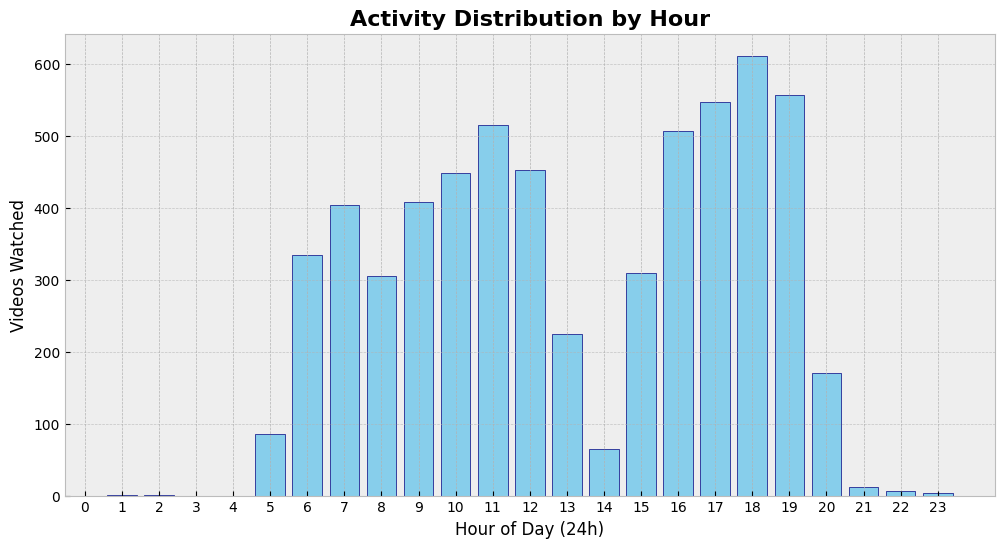

In [49]:
#hourly activity
plt.figure()
hour_counts = history['hour'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values, color='skyblue', edgecolor='navy')

plt.title('Activity Distribution by Hour', fontweight='bold')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Videos Watched')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

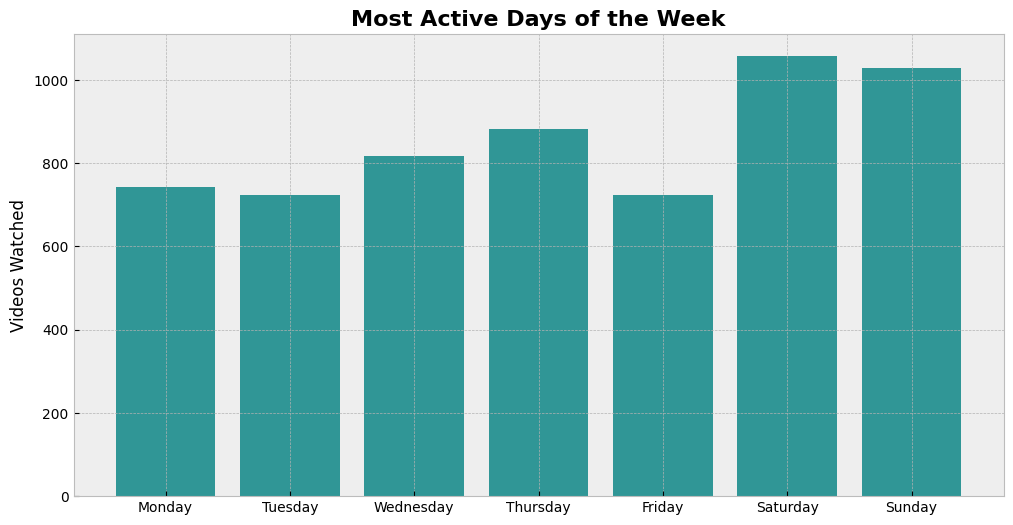

In [50]:
# weekly routine
plt.figure()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = history['day_of_week'].value_counts().reindex(day_order)

plt.bar(day_counts.index, day_counts.values, color='teal', alpha=0.8)
plt.title('Most Active Days of the Week', fontweight='bold')
plt.ylabel('Videos Watched')
plt.show()

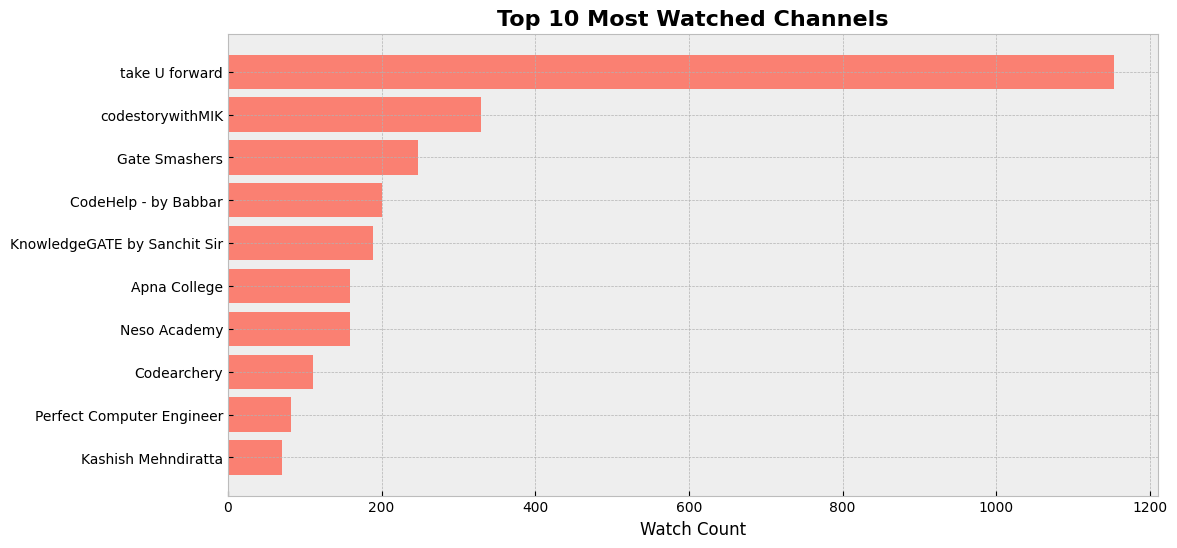

In [51]:
# top 10 channels
plt.figure()
top_10 = history['channel'].value_counts().head(10).iloc[::-1]

plt.barh(top_10.index, top_10.values, color='salmon')
plt.title('Top 10 Most Watched Channels', fontweight='bold')
plt.xlabel('Watch Count')
plt.show()

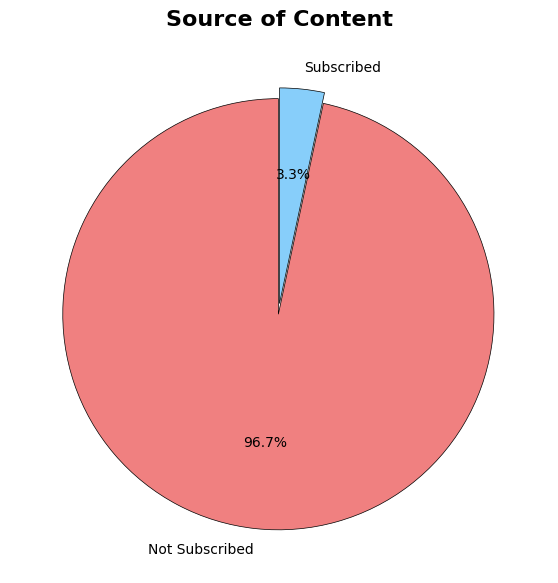

In [52]:
# -subscribed channel Vs unsubscribed channel
plt.figure(figsize=(7, 7))
sub_data = history['is_subscribed'].value_counts()
labels = ['Not Subscribed', 'Subscribed']

plt.pie(sub_data, labels=labels, autopct='%1.1f%%',
        colors=['lightcoral', 'lightskyblue'], explode=(0.05, 0),
        startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Source of Content', fontweight='bold')
plt.show()

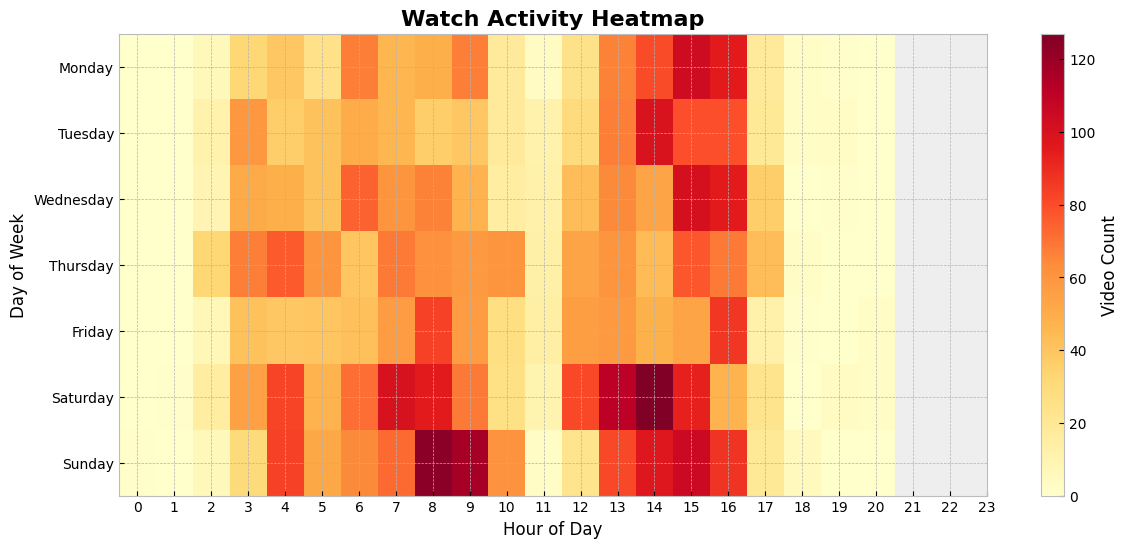

In [53]:
# activity heatmap
heatmap_data = history.groupby(['day_of_week', 'hour']).size().unstack().fillna(0)
heatmap_data = heatmap_data.reindex(day_order)

plt.figure(figsize=(14, 6))
plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')

plt.title('Watch Activity Heatmap', fontweight='bold')
plt.colorbar(label='Video Count')
plt.xticks(range(24))
plt.yticks(range(7), day_order)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

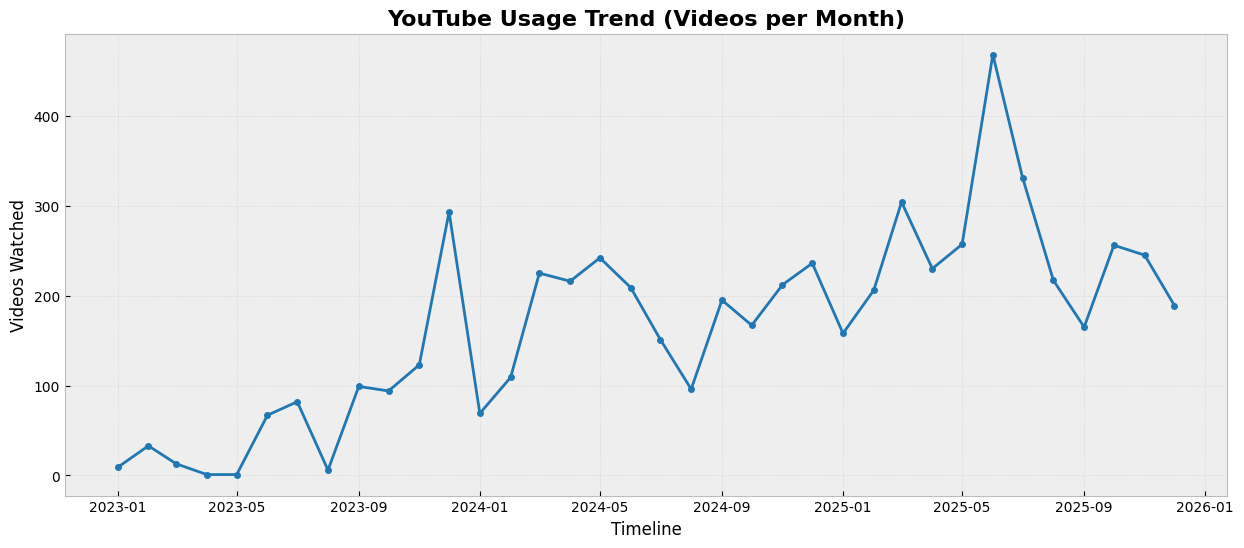

In [55]:
# watch history ove the years
plt.figure(figsize=(15, 6))
history['year_month'] = history['timestamp'].dt.to_period('M')
trend_data = history.groupby('year_month').size()
trend_data.index = trend_data.index.to_timestamp() # Convert back to datetime for plotting

plt.plot(trend_data.index, trend_data.values, color='tab:blue', linewidth=2, marker='o', markersize=4)
plt.title('YouTube Usage Trend (Videos per Month)', fontweight='bold')
plt.xlabel('Timeline')
plt.ylabel('Videos Watched')
plt.grid(True, alpha=0.3)
plt.show()

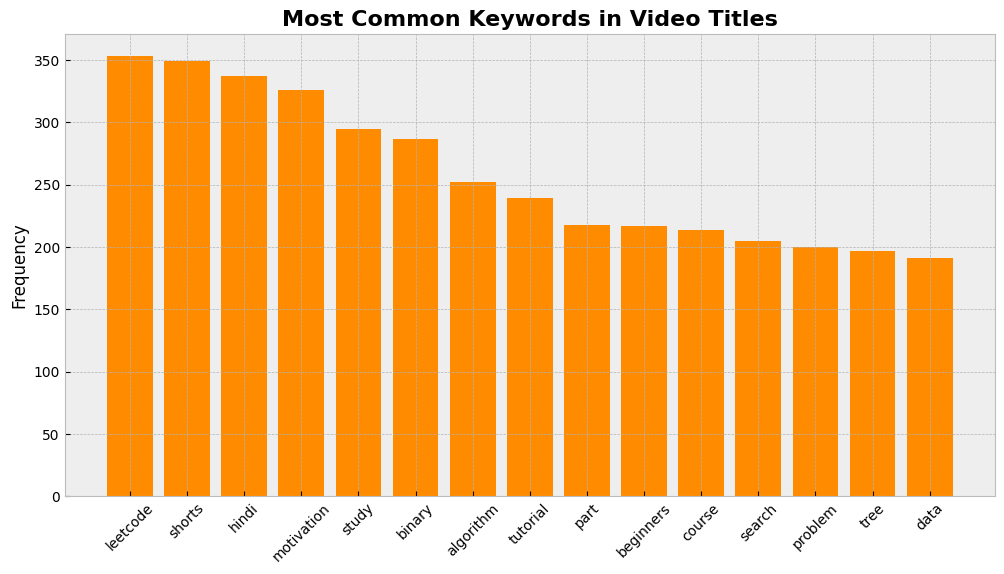

In [57]:
#top keywords in titles
stop_words = set(['the', 'a', 'in', 'to', 'of', 'and', 'for', 'with', 'is', 'on', 'how', 'video', 'my', 'at'])

all_titles = " ".join(history['title'].astype(str)).lower()
words = re.findall(r'\w+', all_titles)
filtered_words = [w for w in words if len(w) > 3 and w not in stop_words]
top_words = Counter(filtered_words).most_common(15)

words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
plt.figure()
plt.bar(words_df['Word'], words_df['Count'], color='darkorange')
plt.title('Most Common Keywords in Video Titles', fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

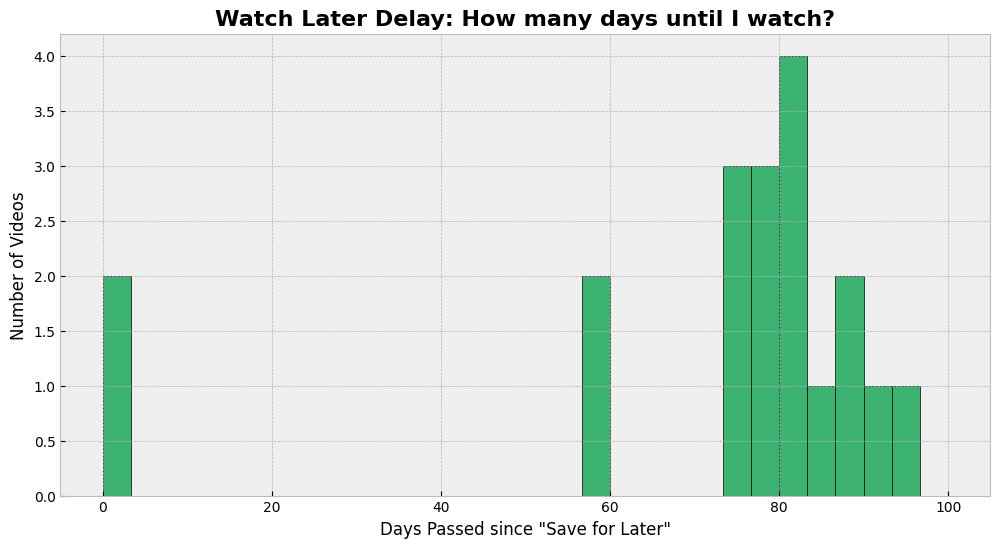

In [58]:
# procstination based on watch delay ... watch later
if 'watch_delay_df' in locals():
    plt.figure()
    plt.hist(watch_delay_df['days_to_watch'], bins=30, color='mediumseagreen', edgecolor='black', range=(0, 100))
    plt.title('Watch Later Delay: How many days until I watch?', fontweight='bold')
    plt.xlabel('Days Passed since "Save for Later"')
    plt.ylabel('Number of Videos')
    plt.show()

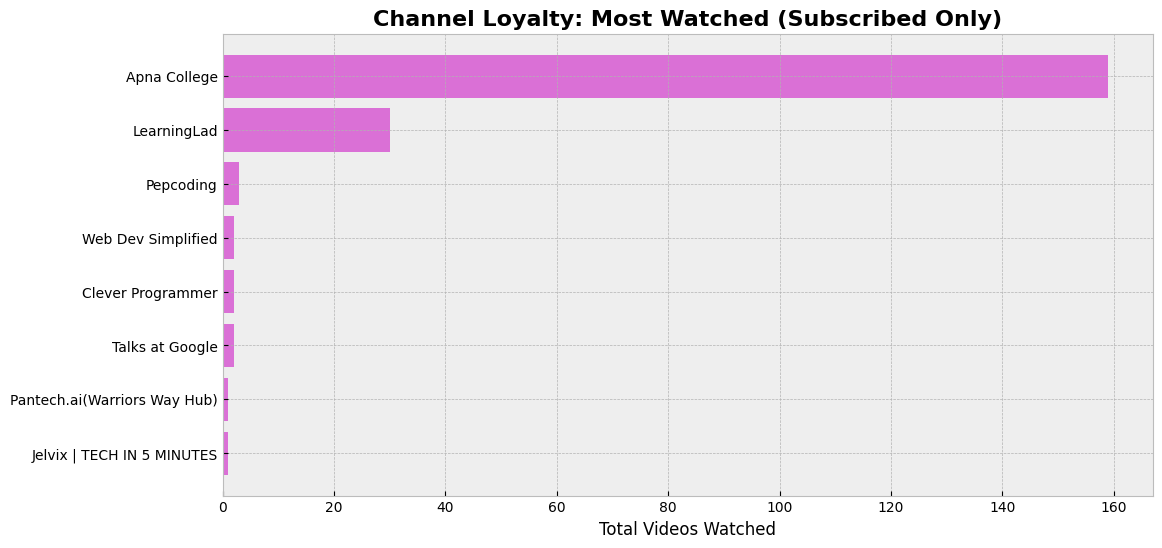

In [59]:
# subscription deptj
plt.figure()
subscribed_history = history[history['is_subscribed'] == True]
loyalty_top = subscribed_history['channel'].value_counts().head(10).iloc[::-1]

plt.barh(loyalty_top.index, loyalty_top.values, color='orchid')
plt.title('Channel Loyalty: Most Watched (Subscribed Only)', fontweight='bold')
plt.xlabel('Total Videos Watched')
plt.show()

In [61]:
#Binge watch analysis

history = history.sort_values('timestamp') # sort by time

history['time_diff'] = history['timestamp'].diff().dt.total_seconds() / 60

history['new_session'] = (history['time_diff'] > 30).astype(int)
history['session_id'] = history['new_session'].cumsum()

# analyze sessions
session_stats = history.groupby('session_id').agg(
    video_count=('title', 'count'),
    total_duration_approx=('time_diff', 'sum'),
    start_time=('timestamp', 'min')
)

# top 5 binge sessions
top_binges = session_stats.sort_values('video_count', ascending=False).head(5)

print("YOUR BINGE-WATCHING STATS:")
print(f"Average Videos per Session: {session_stats['video_count'].mean():.1f}")
print(f"Total Sessions Detected: {len(session_stats)}")
print("\nTop 5 Longest Binge Sessions (by video count):")
print(top_binges[['video_count', 'start_time']])

YOUR BINGE-WATCHING STATS:
Average Videos per Session: 2.4
Total Sessions Detected: 2441

Top 5 Longest Binge Sessions (by video count):
            video_count          start_time
session_id                                 
2340                 31 2025-11-05 10:28:59
226                  28 2023-12-14 07:29:53
542                  27 2024-05-12 18:14:31
1580                 27 2025-05-02 10:56:44
1194                 27 2025-01-11 17:28:31


MODEL TRAINING

In [62]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [63]:
# prepare features
ml_data = history.groupby('session_id').agg({
    'hour': 'mean',
    'is_subscribed': 'mean',
    'is_weekend': 'max',
    'video_id': 'count' # Number of videos in that session
}).rename(columns={'video_id': 'session_size'})

In [64]:
# standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ml_data)

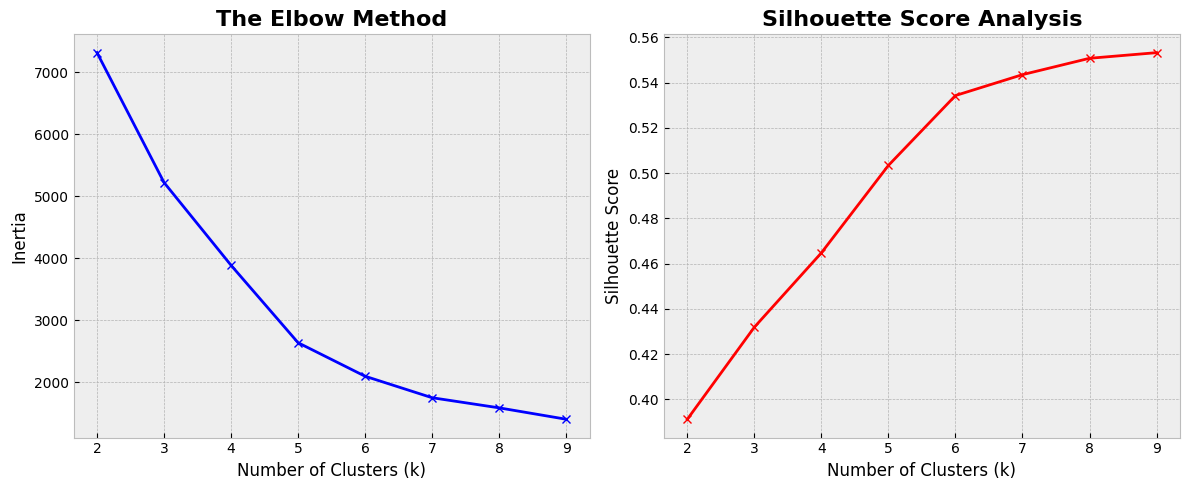

In [70]:
from sklearn.metrics import silhouette_score

inertia = []
silhouette_avg = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    inertia.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(scaled_features, cluster_labels))

# elbow method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bx-')
plt.title('The Elbow Method', fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# silhoutte score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_avg, 'rx-')
plt.title('Silhouette Score Analysis', fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [73]:
print(inertia)
print(silhouette_avg)

[7318.693653526032, 5224.533089518103, 3889.2938675564683, 2640.638029681288, 2099.988838725038, 1753.446512172651, 1590.22786411449, 1406.4979197986818]
[np.float64(0.3912663703711928), np.float64(0.43195490875352593), np.float64(0.4648177746125215), np.float64(0.5034540077882961), np.float64(0.534332858340901), np.float64(0.5435678022544267), np.float64(0.5507969838941682), np.float64(0.5532852475413511)]


In [83]:
final_k = 5
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)

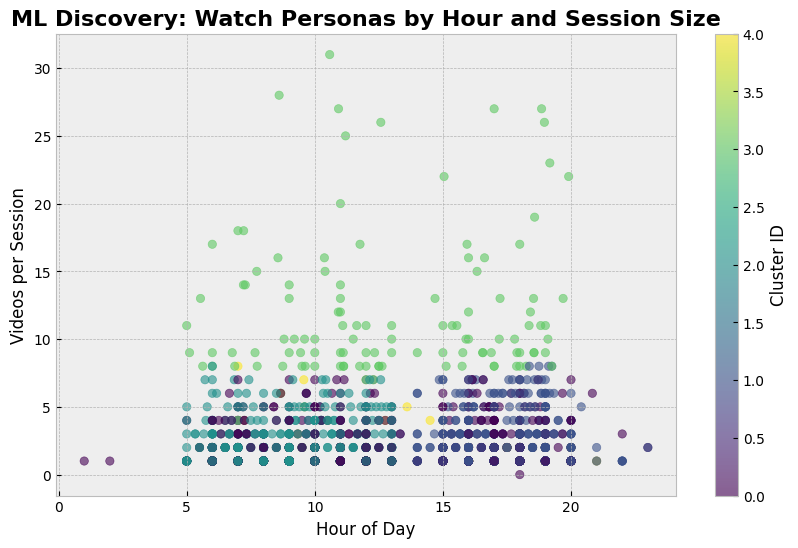

In [84]:
plt.figure(figsize=(10, 6))
plt.scatter(ml_data['hour'], ml_data['session_size'], c=ml_data['cluster'], cmap='viridis', alpha=0.6)
plt.title('ML Discovery: Watch Personas by Hour and Session Size', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Videos per Session')
plt.colorbar(label='Cluster ID')
plt.show()

In [85]:
# Fit and assign to the dataframe
ml_data['cluster'] = kmeans_final.fit_predict(scaled_features)

# Map clusters back to the main history dataframe
history = history.merge(ml_data[['cluster']], on='session_id', how='left')

# Save for Streamlit
history.to_csv('final_youtube_data.csv', index=False)

In [86]:
# analyzing avg val for each cluster
cluster_summary = ml_data.groupby('cluster').agg({
    'hour': 'mean',
    'session_size': 'mean',
    'is_weekend': 'mean'
}).round(2)

print("Cluster Characteristics:")
print(cluster_summary)

Cluster Characteristics:
          hour  session_size  is_weekend
cluster                                 
0        12.76          1.96        1.00
1        17.42          2.08        0.00
2         9.03          1.92        0.00
3        13.01         12.37        0.40
4        13.16          1.88        0.38


In [88]:
if 'cluster' not in history.columns:
    history = pd.merge(history, ml_data[['cluster']], on='session_id', how='left')
#handling missing vals
history['cluster'] = pd.to_numeric(history['cluster'], errors='coerce').fillna(-1).astype(int)

#labels for clusters
cluster_map = {
    0: "The Weekend Wanderer",
    1: "The Post-Work Decompressor",
    2: "The Morning Researcher",
    3: "The Deep-Dive Binger",
    4: "The Casual Scroller",
    -1: "Uncategorized"
}

history['persona'] = history['cluster'].map(cluster_map)

print(history[['title', 'persona']].head())

                                               title  \
0  75% Criteria & JEE MAIN 2023 POSTPONEMENT LATE...   
1  Ye question to pakka ayega😱 NAME Reaction LEAK...   
2  JEE January 2023 Question yahi se aayega 100%g...   
3  Last 15 Days : JEE MAIN 2023 Schedule in 1 min...   
4  JEE Mains 2023 "160 Marks" Complete Checklist ...   

                      persona  
0  The Post-Work Decompressor  
1  The Post-Work Decompressor  
2  The Post-Work Decompressor  
3        The Weekend Wanderer  
4        The Weekend Wanderer  


In [90]:
history.to_csv('final_youtube_data.csv', index=False)